# Lab 12: Pre-trained embeddings for Text

In the last part of [Lab 8](./08_NLP_and_Text_Data.ipynb#Embeddings) we introduced the concept of **Embeddings**. These are dense vectors that represent words and are often used as a starting point when approaching NLP problems like language translation or sentiment analysis. The word vectors we introduced in Lab 8 were trained together with the rest of the model and therefore were specific to the particular problem we were trying to solve.

For example, when we trained our [Recurrent Model](./08_NLP_and_Text_Data.ipynb#Recurrent-model) for the IMDB sentiment analysis task, the embedding layer was the first layer in a Sequential model, followed by a recurrent layer and a classification head for the sentiment prediction. The weights of the word vectors in the embedding layer were learned together with the weights of the recurrent layer and the classification layer. The single task of predicting the sentiment of a movie review would provide a value for the loss which would then propagate back through the network to adjust both the recurrent and the embedding weights.

The approach we have just described has two drawbacks:

1) since the embedding layer has many of weights (e.g., for a vocabulary of 10k words, each embedded with 100 numbers, we have 1M weights), we need lots of data for this model to generalize well and avoid overfitting

2) since the embeddings are trained on the sentiment analysis task, they will work well on that task but will not necessarily learn general properties of the semantic space. In other words, we will not be able to use those same embeddings for an entirely different NLP task, like machine translation.

To overcome these two limitations, researchers have proposed a different approach to building more generic embeddings. These approaches try to capture the meaning of a word in a language and learn more general embeddings where similar vectors represent words with similar meanings. Although this may seem crazy at first, it works well in practice.

In this lab, we will see a couple of different famous embeddings, and we will use them to do fun operations with text.

Let's get started.

## "Unsupervised"-"supervised learning"

How can we train a generic embedding layer that encodes the meaning of words? We'll have to resort to a trick, common when training large networks. This trick is often referred to as "Unsupervised Learning" although, as we shall see, it is a special case of Supervised Learning where humans do not generate the labels.

Let's think back of the [sequence generation](./08_NLP_and_Text_Data.ipynb#Sequence-generation-and-language-modeling) example we introduced in Lab 8. There we built a network that learned to predict the most likely letter after a sequence of 3 letters, using a corpus of English baby names. The same approach can be used to build a model that is trained to predict the most likely word after a sequence of words. For example, if trained using a corpus of songs from John Lennon, the model should be able to learn that "heaven" should be the most likely word after the words "imagine there's no". This task is called **language modeling** because the model learns the structure of a language.

The output of this model is a Softmax over the vocabulary of the language, while the input is a sequence of words encoded as vectors by the input embedding layer of the language model. Since the model is solving a forecasting task (predict the most likely words after a sequence of words), we are still in the domain of Supervised Learning. The labels, however, are contained in the corpus itself.

Consider for example this excerpt from the song [Imagine](https://genius.com/John-lennon-imagine-lyrics) by John Lennon:

In [1]:
text = """
    imagine there's no heaven
    it's easy if you try
    no hell below us
    above us only sky
    imagine all the people living for today
    
    imagine there's no country
    it isn't hard to do
    nothing to kill or die for
    and no religion too
    imagine all the people living life in peace,
    you

    you may say i'm a dreamer
    but i'm not the only one
    i hope some day you'll join us
    and the world will be as one
    
    ...
"""

From this text we can build the following pairs of inputs and labels:


|Sequence|Label|
|:--------:|:--------:|
|imagine there's no|heaven|
|there's no heaven|it's|
|no heaven it's|easy|
|heaven it's easy|if|
|it's easy if|you|
|easy if you|try|
|...|...|


Both the inputs and the labels come from the same corpus by merely sliding a window of fixed length and asking the model to predict the word coming immediately after the window.

This generic forecasting approach is amazingly powerful! Our ability to label data no longer limit us. We can use any text. We could use the whole of Wikipedia, and train a very generic language model that attempts to predict the next word in a sequence. The embeddings of this model must be more generic than the ones trained on the sentiment problem!

Starting with this intuition, that you can obtain labels from the text, researchers have invented several approaches to train generic embeddings. We will mention here a few of the most famous and show you where to find them and how to use them.

Let's start with a very common set of embeddings called [GloVe](https://nlp.stanford.edu/projects/glove/), which stands for Global Vectors for Word Representation.

## GloVe embeddings

In [2]:
with open('common.py') as fin:
    exec(fin.read())

In [3]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

In the `data/embeddings` folder we provide a download script that downloads and extracts GloVe embeddings from: https://nlp.stanford.edu/projects/glove/. Here is its content:

In [4]:
cat ../data/embeddings/glove_download.sh

# Script to download and extract Glove
# word embeddings. More information at:
# https://nlp.stanford.edu/projects/glove/

# Uncomment the file you'd like to download
EMBEDDINGS=glove.6B
# EMBEDDINGS=glove.42B.300d
# EMBEDDINGS=glove.840B.300d

# download and extract
wget http://nlp.stanford.edu/data/$EMBEDDINGS.zip
unzip $EMBEDDINGS.zip
rm $EMBEDDINGS.zip


Go ahead and run the script to retrieve the `glove.6B` embeddings. Let's take a look at them. First let's define a path variable:

In [5]:
glove_path = '../data/embeddings/glove.6B.50d.txt'

And let's look at the first line in the file:

In [6]:
with open(glove_path, 'r', encoding='utf-8') as fin:
    line = fin.readline()

In [7]:
line

'the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581\n'

As you can see the line contains the word `the` as first element, followed by 50 space-separated floating point numbers, which form the word vector. Let's define a parse function that parses the line and returns the word and the vector as a numpy array.

We should take care of removing the trailing `\n` character at the end, then split the line at spaces, which will return a list.
Finally, we'll take the first element in the list as `word` and the remaining values as the vector. Here's the parse function:

In [8]:
def parse_line(line):
    values = line.strip().split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    return word, vector

Now that we have defined a parse function let's use it to load the word embeddings. We will use a Python dictionary for the embeddings and one for the word index. Let's create two empty dictionaries:

In [9]:
embeddings = {}
word_index = {}

Let's also create an empty list for the inverted index that will map numbers to words:

In [10]:
word_inverted_index = []

Now we can loop over the lines in the file, parse each line and store it in the embeddings and word index dictionary. We will `enumerate` the lines as we proceed with the loop so that we can also retrieve their numeric index.

Let's do it:

In [11]:
with open(glove_path, 'r', encoding='utf-8') as fin:
    for idx, line in enumerate(fin):
        word, vector = parse_line(line) # parse a line
        
        embeddings[word] = vector  # add word vector
        word_index[word] = idx  # add idx
        word_inverted_index.append(word)  # append word

Let's check a few entries in the indexes we built. For example, using `word_index`, we can retrieve the line number at which the word `good` appears:

In [12]:
word_index['good']

219

Using the `word_inverted_index` we can do the reverse, i.e., given a line number, find the corresponding word:

In [13]:
word_inverted_index[219]

'good'

The `embeddings` dictionary contains the actual word vectors, so for example, the word vector corresponding to the word `good` is the following:

In [14]:
embeddings['good']

array([-3.5586e-01,  5.2130e-01, -6.1070e-01, -3.0131e-01,  9.4862e-01,
       -3.1539e-01, -5.9831e-01,  1.2188e-01, -3.1943e-02,  5.5695e-01,
       -1.0621e-01,  6.3399e-01, -4.7340e-01, -7.5895e-02,  3.8247e-01,
        8.1569e-02,  8.2214e-01,  2.2220e-01, -8.3764e-03, -7.6620e-01,
       -5.6253e-01,  6.1759e-01,  2.0292e-01, -4.8598e-02,  8.7815e-01,
       -1.6549e+00, -7.7418e-01,  1.5435e-01,  9.4823e-01, -3.9520e-01,
        3.7302e+00,  8.2855e-01, -1.4104e-01,  1.6395e-02,  2.1115e-01,
       -3.6085e-02, -1.5587e-01,  8.6583e-01,  2.6309e-01, -7.1015e-01,
       -3.6770e-02,  1.8282e-03, -1.7704e-01,  2.7032e-01,  1.1026e-01,
        1.4133e-01, -5.7322e-02,  2.7207e-01,  3.1305e-01,  9.2771e-01],
      dtype=float32)

How many components does this vector have? Let's check its length:

In [15]:
embedding_size = len(embeddings['good'])
embedding_size

50

We can also plot it:

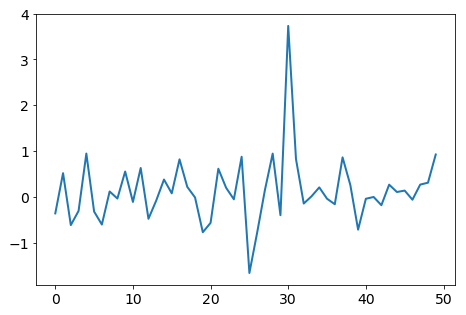

In [16]:
plt.plot(embeddings['good']);

It doesn't tell us much, but for example, we can compare the word vectors of a few words and see how they look. Let's plot a few numbers, like _two_, _three_, and _four_ and a few animals like _cat_, _dog_, and _rabbit_. As you will see numbers will look very similar to one another, and animals will be distinctly different from the numbers:

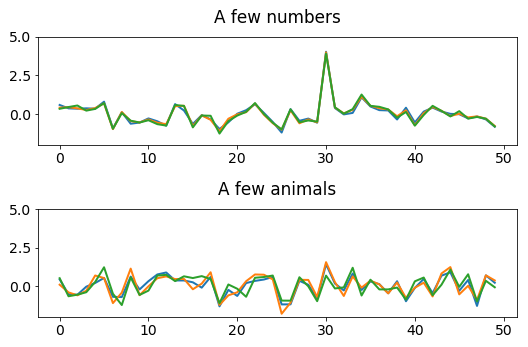

In [17]:
plt.subplot(211)
plt.plot(embeddings['two'])
plt.plot(embeddings['three'])
plt.plot(embeddings['four'])
plt.title("A few numbers")
plt.ylim(-2, 5)

plt.subplot(212)
plt.plot(embeddings['cat'])
plt.plot(embeddings['dog'])
plt.plot(embeddings['rabbit'])
plt.title("A few animals")
plt.ylim(-2, 5)

plt.tight_layout()

This is reminiscent of [Bottleneck features](11_Pretrained_models_for_images.ipynb#Bottleneck-features) we've encountered in Lab 11. Each word corresponds to a vector with fifty numbers and words that carry similar semantic value will be encoded with similar vectors. As we shall see, GloVe vectors are built by looking at co-occurrence of words, so the above plots tell us that numbers like two, three and four are often found near to each other, which makes sense since they appear in similar contexts. I can say: "I ran _two_ miles" or "I ran _three_ miles" and both sentences make sense, while I cannot say "I ran _cat_ miles". _Two_ and _three_ can be found in similar contexts and therefore are encoded as similar vectors.

Let's see how many words are contained in our GloVe embeddings by checking the `len` of the `embeddings` variable:

In [18]:
vocabulary_size = len(embeddings)
vocabulary_size

400000

There are 400000 words in the embeddings, which will cover most of our needs.

> TIP: If you are curious to know more about how to build GloVe embeddings, we encourage you to read the [original paper](https://nlp.stanford.edu/pubs/glove.pdf) or take a look at the [source code](https://github.com/stanfordnlp/GloVe/tree/master/src).

## Loading pre-trained embeddings in Keras

Let's import tensorflow:

In [19]:
import tensorflow as tf

As we have seen in [Lab 8](./08_NLP_and_Text_Data.ipynb), Keras has an `Embedding` layer that can be trained to build custom embeddings. Here we will learn how to initialize it using pre-trained embeddings like the GloVe embeddings we have just loaded. First, let's load the `Sequential` model and the `Embedding` layer from Keras:

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

Next, we are going to arrange our pre-trained embeddings as a giant matrix of shape `(vocabulary_size, embedding_size)`. We will do this in 2 steps. First, let's create a zero matrix with the correct shape:

In [21]:
embedding_weights = np.zeros((vocabulary_size,
                              embedding_size))

Then let's iterate over the items in our `word_index` dictionary and let's assign each vector in the `embeddings` dictionary to a line in the matrix. For example, we know from above that the word `good` has index 219. We will assign its vector to the row in the matrix corresponding to index 219 (i.e., the 220-th row). Let's do it:

In [22]:
for word, index in word_index.items():
    embedding_weights[index, :] = embeddings[word]

Now that we have our pre-trained weights arranged in a matrix, we can create a model with a single `Embedding` layer, and we will then set the weights to be the pre-trained weights.

We start by creating the embedding layer:

In [23]:
emb_layer = Embedding(input_dim=vocabulary_size,
                      output_dim=embedding_size,
                      mask_zero=False,
                      trainable=False)

Notice that we specified the following parameters:
- `input_dim`: this is the number of distinct words to embed, and it is equal to the `vocabulary_size`
- `output_dim`: this is the embedding dimension and it has to coincide with the size of Glove vectors, i.e. 50 in our case.
- `mask_zero`: this tells Keras whether we are using the index 0 as a special padding value or as a word. In our case, the index zero corresponds to the word 'the', so we need to set this flag to `False`
- `trainable`: this tells Keras whether the weights in the embedding layer should be trainable. Since we take weights from Glove, this also should be false.

> TIP: for more info on the `mask_zero` flag, here is its documentation:

    mask_zero: Whether or not the input value 0 is a special "padding"
          value that should be masked out.
          This is useful when using [recurrent layers](recurrent.md)
          which may take variable length input.
          If this is `True` then all subsequent layers
          in the model need to support masking or an exception will be raised.
          If mask_zero is set to True, as a consequence, index 0 cannot be
          used in the vocabulary (input_dim should equal size of
          vocabulary + 1).

In our case, we have used the index 0 in the vocabulary for the word `the`, as we can check in the `word_inverted_index`:

In [24]:
word_inverted_index[0]

'the'

so we have to set `mask_zero` to `False`. Had we started enumerating the word vectors from 1, we could have reserved the 0 value for padding, which, as the doc says, is useful when using recurrent layers.

The `trainable=False` flag tells Keras that this layer is not trainable, i.e., its weights cannot be changed during training. We used this earlier when using pre-trained models for images in [Lab11](11_Pretrained_models_for_images.ipynb).

Notice that simply passing the matrix to the `Embedding` constructor is not enough. We need to put this layer in a model in order for Keras to actually create a Tensorflow graph with it. Let's do it:

In [25]:
model = Sequential()
model.add(emb_layer)

Finally we need to set the weights to be the Glove weights:

In [26]:
model.set_weights([embedding_weights])

Now that we have created a model we can check that the embedding layer does use the pre-trained weights. Let's check the embeddings for the word `cat`. Here are the original values we loaded from the file:

In [27]:
embeddings['cat'] 

array([ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,  0.54602 ,
       -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,  0.33685 ,  0.7735  ,
        0.90094 ,  0.38488 ,  0.38367 ,  0.2657  , -0.08057 ,  0.61089 ,
       -1.2894  , -0.22313 , -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,
        0.60885 , -1.1633  , -1.1579  ,  0.36118 ,  0.10466 , -0.78325 ,
        1.4352  ,  0.18629 , -0.26112 ,  0.83275 , -0.23123 ,  0.32481 ,
        0.14485 , -0.44552 ,  0.33497 , -0.95946 , -0.097479,  0.48138 ,
       -0.43352 ,  0.69455 ,  0.91043 , -0.28173 ,  0.41637 , -1.2609  ,
        0.71278 ,  0.23782 ], dtype=float32)

Now let's retieve the index of the word `cat` and let's pass it to the `model.predict` method. First we retrieve the index of the word `cat` using the `word_index`:

In [28]:
cat_index = word_index['cat']

The index is:

In [29]:
cat_index

5450

Now that we have the index, we run `model.predict` on a double nested list containing the single index of the word `cat`:

> TIP: we need to use a list here because the `predict` method expects as input an integer matrix of size (batch, input_length), as explained in the [documentation](https://keras.io/layers/embeddings/) and here we have a batch of 1 point with a sequence of 1 word.

In [30]:
model.predict([[cat_index]])

array([[[ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,
          0.54602 , -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,
          0.33685 ,  0.7735  ,  0.90094 ,  0.38488 ,  0.38367 ,
          0.2657  , -0.08057 ,  0.61089 , -1.2894  , -0.22313 ,
         -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,  0.60885 ,
         -1.1633  , -1.1579  ,  0.36118 ,  0.10466 , -0.78325 ,
          1.4352  ,  0.18629 , -0.26112 ,  0.83275 , -0.23123 ,
          0.32481 ,  0.14485 , -0.44552 ,  0.33497 , -0.95946 ,
         -0.097479,  0.48138 , -0.43352 ,  0.69455 ,  0.91043 ,
         -0.28173 ,  0.41637 , -1.2609  ,  0.71278 ,  0.23782 ]]],
      dtype=float32)

As you can see the method returns exactly the same values, so we have successfully initialized a Keras model with a pre-trained embedding.

## Gensim

Gensim is a topic modelling library in Python that contains a lot of functions related to extracting meaning and manipulating text. Let's import it and have some fun with word embeddings:

In [31]:
import gensim

In order to load Glove embeddings using Gensim we need to convert them into the appropriate format. Luckily for us Gensim has a function for that. We just need to import the `glove2word2vec` script:

In [32]:
from gensim.scripts.glove2word2vec import glove2word2vec

and then run it. We first set input and output paths:

In [33]:
glove_path = '../data/embeddings/glove.6B.50d.txt'
glove_w2v_path = '../data/embeddings/glove.6B.50d.txt.vec'

In [34]:
glove2word2vec(glove_path, glove_w2v_path)

(400000, 50)

Next we use the `gensim.models.KeyedVectors.load_word2vec_format` to load the word vectors from the file:

In [35]:
from gensim.models import KeyedVectors

In [36]:
glove_model = KeyedVectors.load_word2vec_format(
    glove_w2v_path, binary=False)

Now that we have loaded the vectors into a Gensim model, we have access to a lot of functionality. For example, we can quickly find what are the most similar words to a given word.

Here's how we look for the five closest words to the word `good`:

In [37]:
glove_model.most_similar(positive=['good'], topn=5)

[('better', 0.9284390807151794),
 ('really', 0.9220625162124634),
 ('always', 0.9165270328521729),
 ('sure', 0.9033513069152832),
 ('something', 0.9014205932617188)]

The `.most_similar` method allows for both a list of `positive` and `negative` words. Feel free to play with the list of words to get a feel for how they affect the output. The closest words to `good` are words that can appear in the same context as good, so it's quite obvious that we should get similar adjectives like `better` or adverbs like `really` and `always`.

If we try with the number `two` we should get other numbers:

In [38]:
glove_model.most_similar(positive=['two'], topn=5)

[('three', 0.9885902404785156),
 ('four', 0.9817472696304321),
 ('five', 0.9644663333892822),
 ('six', 0.964131236076355),
 ('seven', 0.9512959718704224)]

### Word Analogies

Since word vectors are vectors, we can do any vector operation with them, including addition, subtraction and dot products. For example we can perform operations between words like:

    result = king - man + woman

where the vector `result` is a perfectly valid vector in the embedding space. Using the `.most_similar` method, we can look for the three vectors closest to `result`. Can you guess which vector will be the closest?

If you guessed `queen`, which is the feminine counterpart of `king`, you guessed right. Let's see it in action:

In [39]:
glove_model.most_similar(positive=['king', 'woman'],
                         negative=['man'], topn=3)

[('queen', 0.8523603677749634),
 ('throne', 0.7664333581924438),
 ('prince', 0.7592144012451172)]

i.e. we have found that

    queen ~ king - man + woman

Another way to look at this is to say that the vector `queen - king` is similar to the vector `woman - man`. This is often described with this famous picture:

![Semantic relations in embedding space](./assets/manwomankingqueen.png)

In this figure, we imagine an embedding space that has only two axes (instead of 50 or 300), and we represent the words as points in the embedded space. The arrows represent the vector distances between the words.

Since this chart can be useful to understand how the model is representing the semantic space, it's legitimate to ask if we can visualize all of glove words in a similar chart using a [dimensionality reduction]() technique. The answer to this question is yes, and we can actually leverage tensorboard for this. We'll see how in the next Section.

## Visualization

Tensorboard also contains a projector that allows us to explore word embeddings visually. Let's save our word embeddings and let's visualize them in Tensorboard. First we need to create an output folder. We'll use the `/tmp/ztdl_models/embeddings/` folder for output. We will need the `os` module:

In [40]:
import os

Then let's define a path variable that we'll use later too:

In [41]:
model_dir = '/tmp/ztdl_models/embeddings/'

Let's also load the `rmtree` function from `shutil` so that we can delete the directory if it already exists:

In [42]:
from shutil import rmtree

In [43]:
rmtree(model_dir, ignore_errors=True)

Finally let's create the folder:

In [44]:
os.makedirs(model_dir)

For the purposes of this visualization we will limit our Embedding layer to the top most frequent 4000 words in the glove set. Let's set a variable called `n_viz` to 4000 (you can change this number if you wish):

In [45]:
n_viz = 4000

Let's create a new embedding layer, with only 4000 x 50 weights. Notice that we still pass the `mask_zero=False` parameter since our first vector, corresponding to the index 0, is the word `the`:

In [46]:
emb_layer_viz = Embedding(n_viz,
                          embedding_size,
                          mask_zero=False,
                          trainable=False)

Let's stick this layer into a Sequential model so that the weights get initialized:

In [47]:
model = Sequential([emb_layer_viz])

and let's set the weights to Glove:

In [48]:
model.set_weights([embedding_weights[:n_viz]])

Now let's visualize these embeddings. The [most recent documentation](https://www.tensorflow.org/alpha/tutorials/sequences/word_embeddings) on how to do this suggests to create a separate tsv file for the weights and the metadata. We will choose a different route, saving the model as a [Checkpoint](https://www.tensorflow.org/alpha/guide/checkpoints) and attaching the metadata to it with a small config file.

Note that in Tensorflow you can save a model as a `Checkpoint` or as a `SavedModel`. We'll use checkpoints here, and saved models in the next lab for serving

We need to accomplish three things, which are independent:
- save a model checkpoint
- save a file with the words (metadata)
- save a configuration file that binds the metadata to the embedding tensor

Let's start by saving the model:

In [49]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.save(os.path.join(model_dir, 'model.ckpt'))

'/tmp/ztdl_models/embeddings/model.ckpt-1'

This operation creates a few files in the `model_dir` folder, as you can see with the `os.listdir` command:

In [50]:
os.listdir(model_dir)

['model.ckpt-1.index', 'model.ckpt-1.data-00000-of-00001', 'checkpoint']

These files contain the weights, but have no information about which word corresponds to each vector. What we need is a `metadata.tsv` file with the list of words. We can easily create it by looping over the indexes from 0 to `n_viz` adding one word per line to the file:

In [51]:
fname = os.path.join(model_dir, 'metadata.tsv')

with open(fname, 'w', encoding="utf-8") as fout:
    for index in range(0, n_viz):
        word = word_inverted_index[index]
        fout.write(word + '\n')

You can check the content of this file and see that it contains one word per line like:

    the
    ,
    .
    of
    to
    and
    ...

This file can be associated to the model using a small configuration file.

In [52]:
config_string = """
embeddings {
  tensor_name: "model/layer_with_weights-0/embeddings/.ATTRIBUTES/VARIABLE_VALUE"
  metadata_path: "metadata.tsv"
}
"""

In [53]:
fname = os.path.join(model_dir, 'projector_config.pbtxt')

with open(fname, 'w', encoding="utf-8") as fout:
    fout.write(config_string)

> TIP: As noted above, we could also save the weights and the metadata as tsv and then load them in the Tensorboard projector. This is explained in the [Tensorflow 2.0 guide](https://www.tensorflow.org/alpha/tutorials/sequences/word_embeddings).

We can now start [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard):

    tensorboard --logdir=/tmp/ztdl_models/embeddings/

and point our browser to:

    http://localhost:6006/#projector

We should see the word embedding projector spinning. Using the `Search` tab on the right, let's look for a specific word, for example, the word `network` and see what the closest words are. You should see something like this:

![Tensorflow projector](./assets/projector.png)

You can also uncomment the next two cells to display Tensorboard in the notebook.

In [54]:
# %load_ext tensorboard.notebook

In [55]:
# %tensorboard --logdir /tmp/ztdl_models/embeddings/

## Other pre-trained embeddings

We have learned how to use and visualize pre-trained embeddings using GloVe. GloVe is a commonly used set of pre-trained embeddings, but it's not the only one. We will briefly introduce here two other trendy sets of pre-trained embeddings: _Word2Vec_ and _FastText_.

### Word2Vec

[Word2Vec](https://code.google.com/archive/p/word2vec/) is a set of word vectors introduced by Google in 2013. These vectors also try to encapsulate the meaning of a word by looking at its context, i.e., the words that precede it and follow it.

You can find a detailed tutorial on how to build Word2Vec vectors in the [Tensorflow Tutorials page](https://www.tensorflow.org/tutorials/representation/word2vec). The two main useful ideas are the _Skip-gram Model_ and the _noise-contrastive estimation (NCE) loss_. Let's take a look at these in a bit more detail.

#### Skip-grams

Skip-grams are simply pairs of words that appear in context. Let's consider the first two lines of the song imagine:

```
imagine there's no heaven it's easy if you try
```

and let's focus on the word _heaven_. If we choose a context of -2, +2 words, we see that the following words appear in the context of heaven:
- _there's_
- _no_
- _it's_
- _easy_

We could, therefore, try to build a model that takes a word in input and tries to predict the probability that another word in the dictionary appears in its context by using input/output pairs like:

|INPUT|OUTPUT|
|:---:|:---:|
|heaven|there's|
|heaven|no|
|heaven|it's|
|heaven|easy|

We could use a Softmax over the whole dictionary and eventually learn these probabilities. However, this would require a massive amount of data, since the dictionary size is enormous.

Hence, Word2Vec is trained using a trick called _Negative Sampling_.

#### Negative Sampling and the noise-contrastive estimation (NCE) loss

Imagine solving a slightly different problem where instead of having a word as input and a word as output, we have a pair as input and a binary label as output. We can use the pairs above as positive examples, since they are actual pairs found in the training text, and we can build fake pairs that have the same first word and a random second word. Our data will look like this:

|INPUT|OUTPUT|
|:---:|:---:|
|(heaven, there's)|1|
|(heaven, no)|1|
|(heaven, it's)|1|
|(heaven, easy)|1|
|(heaven, cat)|0|
|(heaven, brain)|0|
|(heaven, swimming)|0|
|(heaven, chair)|0|
|...|...|

We have constructed negative pairs by randomly choosing words from the dictionary. This model learns to predict the probability that given a first word, the second word is in its context or not, which is the same problem as before. However, this model is much faster to train, because we are only choosing a small set of negative examples at each batch instead of having the whole dictionary.

These two tricks allow training Word2Vec quite easily. In our case, we will not even train it but rely on a pre-trained version of these embeddings that's been trained using data from Google News.

> TIP: if you want to learn more about Word2Vec we encourage you to read the [Wikipedia page](https://en.wikipedia.org/wiki/Word2vec) and to go through the [tutorial](https://www.tensorflow.org/tutorials/representation/word2vec) mentioned earlier.

### FastText

[FastText](https://fasttext.cc/) is a library for efficient learning of word representations and sentence classification developed by Facebook Research. It is open-source, free and lightweight and it allows users to learn text representations and text classifiers. [Here](https://github.com/facebookresearch/fastText) is the Github repository and [here](https://fasttext.cc/blog/2016/08/18/blog-post.html) you can read the blog post announcing its publication.

FastText has two exciting aspects.

1) fastText word vectors are built from vectors of substrings of characters contained in it. This allows building vectors even for misspelled words or concatenation of words.

2) fastText has been designed to work on a variety of languages by taking advantage of their morphological structure. So, pre-trained vectors are available for many other languages besides English.

You can download the pre-trained English vectors [here](https://fasttext.cc/docs/en/english-vectors.html).
You can download the pre-trained vectors for many other languages [here](https://fasttext.cc/docs/en/crawl-vectors.html)

In the exercises we will use these vectors and compare their results with GloVe and Word2Vec.

## Exercises

### Exercise 1

Compare the representations of Word2Vec, Glove and FastText. In the `data/embeddings` folder we provided you with two additional scripts to download FastText and Word2Vec. Go ahead and download each of them into the `data/embeddings`. Then load each of the 3 embeddings in a separate Gensim model and complete the following steps:

1. define a list of words containing the following words: 'good', 'bad', 'fast', 'tensor', 'teacher', 'student'.
- create a function called `get_top_5(words, model)` that retrieves the top 5 most similar words to the list of words and compare what the 3 different embeddings give you
- apply the same function to each word in the list separately and compare the lists of the 3 embeddings.
- explore the following word analogies:


    man:king=woman:? ==> expected queen
    france:paris=germany:? ==> expected berlin
    teacher:teach=student:? ==> expected learn
    cat:kitten=dog:? ==> expected puppy
    english:friday=italiano:? ==> expected venerdì

Can word analogies be used for translation?

Note that loading the vector may take several minutes depending on your computer.

### Exercise 2

The [Reuters Newswire topic classification dataset](https://keras.io/datasets/#reuters-newswire-topics-classification) is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. This dataset is provided in the `keras.datasets` module and it's easy to use.

Let's compare the performance of a model using pre-trained embeddings with a model using random embeddings on the topic classification task.

- Load the data from `keras.datasets.reuters`
- Retrieve the word index and create the reverse_word_idx as done for IMDB in [Lab 8](8_NLP_and_Text_Data.ipynb).
- Augment the reverse word index with `pad_char`, `start_char` and `oov_char` at indices 0, 1, 2 respectively.
- Check the maximum length of a newswire and use the `pad_sequences` function to pad everything to that 100 words.
- Create and train two models, one using pre-trained embeddings and the other using a randomly initialized embedding
- Compare their performance on this dataset using a recurrent model. In particular, check which of the two models shows the worst overfitting.